In [1]:
from __future__ import division, print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

In [2]:
from sm_funcs import get_spectral_type
import sm_funcs


We have to simulation the stars and the planets that orbit those stars, so first we are going to make up a population of stars.

The first thing to do is to get all the stars observed by Kepler, we can get this from the MAST.
Then load the masses and then assign a one or fewer binary companions. Binary distributions is Raghavan et al. 2010.



In [3]:
keplerstellar = pd.read_csv('../data/kepler_stellar17.csv.gz', delimiter='|')
allquarters = keplerstellar.st_quarters == 11111111111111111
isGoodData = np.isfinite(keplerstellar.mass) & (keplerstellar.st_radius < 3.5)

In [4]:
# we want interpolate a relationship between temperate and absolute magnitude

mamajek = pd.read_table('../data/EEM_dwarf_UBVIJHK_colors_Teff.txt', 
                        skiprows=20, delim_whitespace=True, skipfooter=440,
                        engine='python', na_values=['...','....','.....'])
mamajek.columns = [c.replace('-', '_') for c in mamajek.columns]


mamajek.loc[:,'Mr'] =   - mamajek.loc[:,'Mv'] - mamajek.loc[:,'V_Rc']



In [5]:
# from Raghavan et al. 2010

# orbital period distribution
logPeriod = np.random.normal(5.03,2.28, size=keplerstellar.shape[0])

#for OBAFMKMLT
binaryProbability = {'O': 0.75, 
                      'B': 0.70, 
                      'A': 0.70, 
                      'F': 0.50,
                      'G': 0.41,
                      'K': 0.41,
                      'M': 0.35,
                      'L': 0.20,
                      'T': 0.20,
                      }

# mass ratio can be approximated by a uniform
# but it may be better estimated by distribution that increases toward higher number
# so I'll use uniform in (e - e^(x)) / (e - 1)
massRatio = (np.e-np.e**(np.random.uniform(size=keplerstellar.shape[0]))) / (np.e-1.0)
mp = keplerstellar['mass'].copy()
compMass = mp * massRatio

# we need to companion mass to be in the stellar range, so > 0.08
while np.any(compMass < 0.08):
    nSmall = np.shape(compMass[compMass < 0.08])[0]
    massRatio[compMass < 0.08] = (np.e-np.e**(np.random.uniform(size=nSmall))) / (np.e-1.0)
    compMass[compMass < 0.08] = mp[compMass < 0.08] * massRatio[compMass < 0.08]


Now we need to go through the catalog and assign a binary companion

In [6]:
# let's make some new columns that we'll need

stype_arr = np.empty(keplerstellar.shape[0], dtype='str')
isBinary_arr = np.empty(keplerstellar.shape[0], dtype='bool')

for idx in tqdm(range(keplerstellar.shape[0])):
    stype = get_spectral_type(keplerstellar['teff'][idx])
    stype_arr[idx] = stype
    isBinary_arr[idx] = binaryProbability[stype]  <  np.random.uniform()




100%|██████████| 200038/200038 [00:06<00:00, 31537.80it/s]


In [7]:
# which star should the planet orbit
# we'll say it's 50/50 unless the companion is an M-dwarf
# let's say that the max mass of an M-dwarf is 0.55 Msun
# and let's say that if it's an M-dwarf, the probability the planet's around a companion is 2.5/0.689

orbitProb = np.where(compMass<=0.55, 1. - (0.689/2.5), 0.5)
orbitsPrimary = np.where(np.random.uniform(size=keplerstellar.shape[0]) > orbitProb, True, False)


In [110]:
# it's a factor of a few hundred times faster to loop and add to the dataframe
keplerstellar['stype'] = stype_arr
keplerstellar['isBinary'] = isBinary_arr
keplerstellar['massRatio'] = massRatio
keplerstellar['period'] = np.e**logPeriod
keplerstellar['compMass'] = compMass
keplerstellar['orbitsPrimary'] = orbitsPrimary
keplerstellar['hostMass'] = np.where((isBinary_arr & orbitsPrimary) | ~isBinary_arr, 
                                     keplerstellar.mass, compMass)


In [9]:
# now let's make an array that excludes things we don't want
q = keplerstellar[allquarters & isGoodData]

OK, now we need to start putting planets around these stars. We're going to use Fressin's catalog for all stars except M-dwarfs and use Dressing's number for M-dwarfs. 

For the time being we are going to make the assumption that every star has a planet

In [109]:
#some parameters we will need later

# let's make them all transit
# q.loc[:,'cosi'] = pd.Series(np.random.random(size=q.shape[0]),name='cosi')

q.loc[:,'noise_level'] = sm_funcs.kepler_noise_6h(q.loc[:,'kepmag']) * np.sqrt(6)


In [11]:
# add planets
# first draw planets

mdwarfplanets = sm_funcs.Dressing15_select(q.shape[0])
otherplanets = sm_funcs.Fressin13_select(q.shape[0])

# then assign either a planet from Fressin or Dressing
[planetRadius, planetPeriod] = np.where((q.stype == 'M') | ((q.compMass <=0.55) & q.isBinary), mdwarfplanets, otherplanets )



In [12]:
q.loc[:,'planetRadius'] = planetRadius
q.loc[:,'planetPeriod'] = planetPeriod
q.loc[:,'rprs'] = sm_funcs.get_rprs(planetRadius, q.hostMass)
q.loc[:, 'ars'] = sm_funcs.per2ars(planetPeriod, q.mass, q.hostMass)

# need a fudge here to stop a/r* < 1
q.loc[:, 'ars'] = np.where(q.loc[:, 'ars'] < 1.0, 1.01, q.loc[:, 'ars'])

q.loc[:, 'duration'] = sm_funcs.get_duration(planetPeriod, q.ars, rprs=q.rprs)

In [13]:
q.loc[:,'duration_correction'] = np.sqrt(q.duration * 24.) # correction for CDPP because transit dur != 1 hour
q.loc[:,'transit_depth_undiluted']  = sm_funcs.get_transit_depth(q.planetRadius, q.hostMass)

In [80]:
# we need to go from undiluted transit depth to diluted transit depth
# so we have deltaF / F1 and we want deltaF/(F1+F2)

# so if rprs**0.5 = deltaF / F1
# tm=tm+(1.0d0-tm)*dil-1.0d0
# where dil is F1 / (F1+F2)

# we should do this calculation in magnitude
# so take the kepmag and estimate the kepmag for a companion

m = np.isfinite(mamajek.loc[:,'Mr']) & np.isfinite(mamajek.loc[:,'Msun'])

Mr_primary = np.interp(q.loc[:,'mass'],
                       mamajek.loc[:,'Msun'][m][::-1], mamajek.loc[:,'Mr'][m][::-1], np.nan, np.nan)
Mr_companion = np.interp(q.loc[:,'compMass'],
                       mamajek.loc[:,'Msun'][m][::-1], mamajek.loc[:,'Mr'][m][::-1], np.nan, np.nan)

f1 = 10**(-Mr_primary/2.5)
f2 = 10**(-Mr_companion/2.5)
dil = np.where(q.orbitsPrimary, f1/(f1+f2), f2/(f1+f2))
q['dil'] = dil
q['transit_depth_diluted'] = (q.loc[:,'transit_depth_undiluted'] -dil) * dil -1.0

/Users/tom/.virtualenvs/p2/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tom/.virtualenvs/p2/lib/python2.7/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(0, 50000)

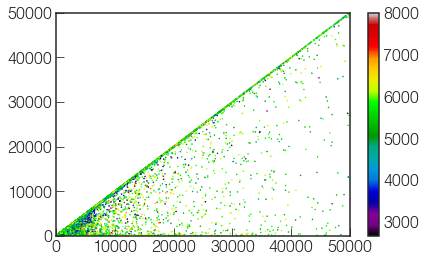

In [81]:
plt.scatter(q.transit_depth_undiluted, q.transit_depth_diluted, c=q.teff, cmap='spectral',vmax=8000, s=1)
plt.colorbar()
plt.xlim(0,50000)
plt.ylim(0,50000)

In [88]:
# finally, we need to build a detection model
# the detection can be a simple SNR threshold, let's pick 8 sigma
# so the probability of detection is if
# SNR > 8
# SNR = sqrt(ntransits) * duration_correction * transit_depth / noise
keplerduration = 4.0 * 365.
ntransits = np.around(keplerduration / q.planetPeriod )
sigma_threshold = 8.0

needed_for_detection_diluted = (q.transit_depth_diluted * q.duration_correction *
                    np.sqrt(ntransits)) / sigma_threshold
detected_diluted = q.noise_level < needed_for_detection_diluted

needed_for_detection_undiluted = (q.transit_depth_undiluted * q.duration_correction *
                    np.sqrt(ntransits)) / sigma_threshold
detected_undiluted = q.noise_level < needed_for_detection_undiluted

In [89]:
print(np.nonzero(detected_diluted)[0].shape)
print(np.nonzero(detected_undiluted)[0].shape)

(66306,)
(92260,)


/Users/tom/.virtualenvs/p2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


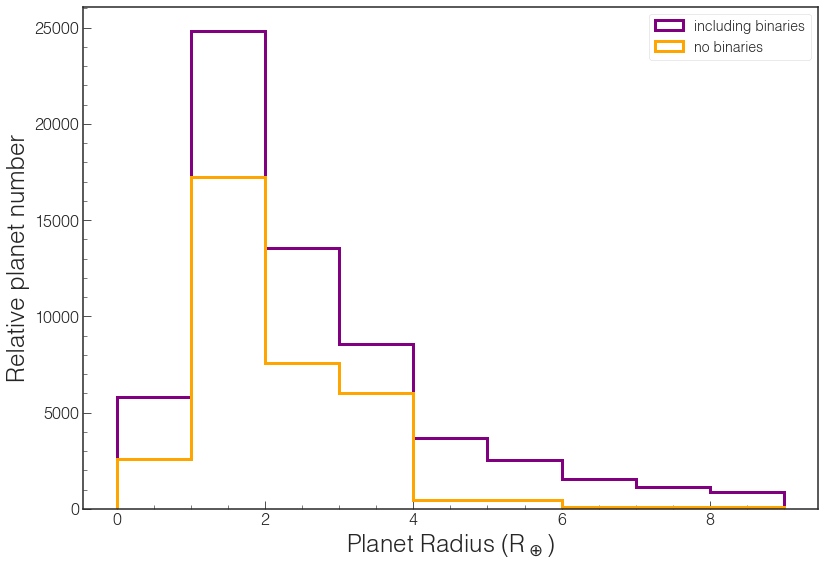

In [131]:
# !!!! this needs to be changed
# becuse I have assumed that stellar radius == stellar mass
# I need to calculate a radius of the companion

fig = plt.figure(figsize=[12,9])

plt.hist(np.sqrt(q.transit_depth_diluted* 1.E-6)[detected_diluted] * q.mass[detected_diluted] / 0.009155, 
         bins=np.arange(0,10,1), 
         histtype='step', lw=3, color='purple',#, normed=True
         label='including binaries',
        )
plt.hist(np.sqrt(q.transit_depth_undiluted* 1.E-6)[detected_undiluted][q.orbitsPrimary] * q.hostMass[detected_undiluted][q.orbitsPrimary] / 0.009155, 
         bins=np.arange(0,10,1),
         histtype='step', lw=3, color='orange',#, normed=True
         label='no binaries',
        )
plt.legend()
plt.xlabel('Planet Radius (R$_\oplus$)')
plt.ylabel('Relative planet number')

plt.minorticks_on()

(array([  4.99000000e+02,   7.69700000e+03,   4.73200000e+04,
          3.75770000e+04,   7.03100000e+03,   1.66600000e+03,
          8.79000000e+02,   2.37000000e+02,   5.50000000e+01,
          3.60000000e+01]),
 array([  10.26761333,   42.88367013,   75.49972693,  108.11578372,
         140.73184052,  173.34789732,  205.96395412,  238.58001092,
         271.19606772,  303.81212452,  336.42818132]),
 <a list of 10 Patch objects>)

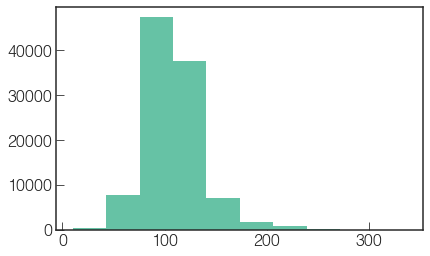

In [121]:
plt.hist(np.sqrt(q.transit_depth_diluted* 1.E-6)[detected_diluted] * q.mass / 0.009155)